## Notebook Overview
- Load ED triage and stay extracts from `mimic-iv-2.2` and inspect admission rates.
- Standardize race categories and explore arrival transport distributions.
- Define physiologic range filters for vital signs and apply them to clean the triage data.
- Merge cleaned triage features with stay outcomes and snapshot key columns for review.
- Export the consolidated dataframe to `combined_data.csv` for downstream modeling.


In [ ]:
from helper_functions.notebook_utils import plot_distribution


In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [11]:
df_triage = pd.read_csv('mimic-iv-2.2/ed/triage.csv')
df_stays = pd.read_csv('mimic-iv-2.2/ed/edstays.csv')

In [12]:
df_stays.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED


In [13]:
df_triage.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [14]:
pct = round((len(df_stays[df_stays['disposition'] == 'ADMITTED'])/len(df_stays))*100, 2)
print(f'Percentage of patients admitted: {pct}%')

Percentage of patients admitted: 37.17%


Here I just want to modify the race column, as there are too many categories representing similar things, such as white, white european descent, etc.

In [15]:
races = df_stays['race'].values
np.unique(races)

array(['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'ASIAN - ASIAN INDIAN',
       'ASIAN - CHINESE', 'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN',
       'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN',
       'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - CENTRAL AMERICAN',
       'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - CUBAN',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN',
       'MULTIPLE RACE/ETHNICITY',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'OTHER',
       'PATIENT DECLINED TO ANSWER', 'PORTUGUESE', 'SOUTH AMERICAN',
       'UNABLE TO OBTAIN', 'UNKNOWN', 'WHITE', 'WHITE - BRAZILIAN',
       'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN',
       'WHITE - RUSSIAN'], dtype=object)

In [16]:
for i in range(len(races)):
    races[i] = races[i].split(' ')[0].split('/')[0]
df_stays['race'] = races

In [17]:
def plot_column_categories(df, column_name):
    column = df[column_name].values
    unique_values = np.unique(column)
    
    total_counts = len(column)
    unique_value_counts = []
    for value in unique_values:
        unique_value_counts.append(len(df[df[column_name] == value]))

    unique_value_counts = np.array(unique_value_counts)

    percentages = (unique_value_counts / total_counts) * 100

    # Sort for presentation
    sorted_indices = np.argsort(percentages)[::-1]  # Get indices for sorting in descending order
    sorted_names = [unique_values[i] for i in sorted_indices]
    sorted_percentages = [percentages[i] for i in sorted_indices]


    bars = plt.bar(sorted_names, sorted_percentages)

    plt.title(f'Distribution of {column_name} in Dataset', fontsize=16)  
    plt.ylabel('Percentage')  

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right') 

    # Display the percentage values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def unique_values(df, column_name):
    column = df[column_name].values
    return np.unique(column)

In [ ]:
def check_nan_or_zero_percentage(df, column_name):    total_rows = len(df)    total_nan_or_zero = df[column_name].isna().sum() + (df[column_name] == 0).sum()    percentage_nan_or_zero = (total_nan_or_zero / total_rows) * 100    return percentage_nan_or_zeroimport pandas as pddef clean_medical_data(df, column_name, feasible_range):    min_val = feasible_range[0]    max_val = feasible_range[1]        df[column_name] = df[column_name].apply(lambda x: x if min_val <= x <= max_val else float('nan'))    return df

I noticed that in the data there were some physiologically impossible data points, such as a body temperature of 0.1 and a heart rate of 1228, I decided to implement a cleaning function that takes as an input a physiologically feasible range of values, and if the value is outside of it, just replace with NaN. I could also change this function to replace it with a defined minimum or maximum value as well.

In [19]:
feasible_ranges = {
    'temperature': [96, 104],    # Temperature in Fahrenheit
    'heartrate': [20, 300],      # Heart rate in beats per minute
    'resprate': [5, 80],         # Respiratory rate in breaths per minute
    'o2sat': [70, 100],          # Oxygen saturation in percentage
    'sbp': [50, 250],            # Systolic blood pressure in mmHg
    'dbp': [30, 150],             # Diastolic blood pressure in mmHg
    'acuity':[1, 5]
}


In [20]:
columns_of_interest = df_triage.columns[2:10]
for column in columns_of_interest:
    pct = check_nan_or_zero_percentage(df_triage, column)
    print(f'Percent invalid in {column}: {round(pct, 2)}%')

Percent invalid in temperature: 5.51%
Percent invalid in heartrate: 4.02%
Percent invalid in resprate: 4.79%
Percent invalid in o2sat: 4.85%
Percent invalid in sbp: 4.3%
Percent invalid in dbp: 4.49%
Percent invalid in pain: 3.04%
Percent invalid in acuity: 1.64%


In [21]:
def filter_dataframe(df, feasible_ranges):
    for column, (min_val, max_val) in feasible_ranges.items():
        # Remove rows with values outside the feasible range or containing NaN
        df = df[(df[column] >= min_val) & (df[column] <= max_val) & (~df[column].isnull())]
    return df

In [22]:
test_df = df_triage.copy()
new_df = filter_dataframe(test_df, feasible_ranges)

In [23]:
columns_of_interest = new_df.columns[2:10]
for column in columns_of_interest:
    pct = check_nan_or_zero_percentage(new_df, column)
    print(f'Percent invalid in {column}: {round(pct, 2)}%')

Percent invalid in temperature: 0.0%
Percent invalid in heartrate: 0.0%
Percent invalid in resprate: 0.0%
Percent invalid in o2sat: 0.0%
Percent invalid in sbp: 0.0%
Percent invalid in dbp: 0.0%
Percent invalid in pain: 0.8%
Percent invalid in acuity: 0.0%


In [27]:
np.unique(df_stays['arrival_transport'].values)

array(['AMBULANCE', 'HELICOPTER', 'OTHER', 'UNKNOWN', 'WALK IN'],
      dtype=object)

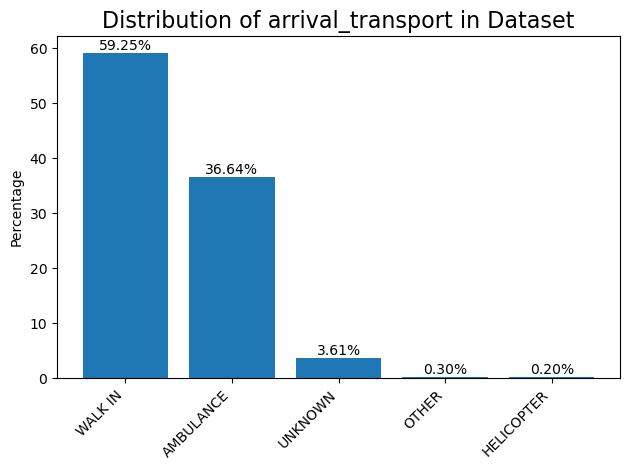

In [28]:
plot_column_categories(df_stays, 'arrival_transport')

In [228]:
merged_df = pd.merge(new_df, df_stays, on='stay_id', how='left')

# Some modifications of the dataframe for better visualization
merged_df.drop(columns=['subject_id_y', 'pain'], inplace=True)
merged_df.rename(columns={'subject_id_x': 'subject_id'}, inplace=True)

# Reorder columns
desired_order = ['subject_id', 'stay_id', 'hadm_id', 'intime', 'outtime',
                 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp',
                 'dbp', 'acuity', 'chiefcomplaint', 'gender', 'race',
                 'arrival_transport', 'disposition']

merged_df = merged_df[desired_order]

# Move chiefcomplaint right before disposition
chiefcomplaint_col = merged_df.pop('chiefcomplaint')
merged_df.insert(len(merged_df.columns) - 1, 'chiefcomplaint', chiefcomplaint_col)

merged_df = merged_df[(merged_df['arrival_transport']=='WALK IN') | (merged_df['arrival_transport']=='AMBULANCE')]
merged_df.reset_index(drop=True, inplace=True)

times = np.zeros((len(merged_df),))
for i in range(len(merged_df)):
    string_time = merged_df['intime'][i].split(' ')[1].split(':')
    times[i] = round(float(string_time[0]) + (float(string_time[1])/60), 2)

merged_df.insert(loc=5, column='time_of_day', value=times)


merged_df

,subject_id,stay_id,hadm_id,intime,outtime,time_of_day,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,gender,race,arrival_transport,chiefcomplaint,disposition
0,10000032,32952584,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,16.40,97.8,87.0,14.0,97.0,71.0,43.0,2.0,F,WHITE,AMBULANCE,Hypotension,HOME
1,10000032,33258284,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,19.28,98.4,70.0,16.0,97.0,106.0,63.0,3.0,F,WHITE,AMBULANCE,"Abd pain, Abdominal distention",ADMITTED
2,10000032,35968195,25742920.0,2180-08-05 20:58:00,2180-08-06 01:44:00,20.97,99.4,105.0,18.0,96.0,106.0,57.0,3.0,F,WHITE,AMBULANCE,"n/v/d, Abd pain",ADMITTED
3,10000032,38112554,22841357.0,2180-06-26 15:54:00,2180-06-26 21:31:00,15.90,98.9,88.0,18.0,97.0,116.0,88.0,3.0,F,WHITE,AMBULANCE,Abdominal distention,ADMITTED
4,10000032,39399961,29079034.0,2180-07-23 05:54:00,2180-07-23 14:00:00,5.90,98.7,77.0,16.0,98.0,96.0,50.0,2.0,F,WHITE,AMBULANCE,"Abdominal distention, Abd pain, LETHAGIC",ADMITTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376207,19999784,34149746,25715748.0,2119-08-11 09:15:00,2119-08-11 13:40:00,9.25,98.8,92.0,18.0,100.0,122.0,77.0,3.0,M,BLACK,WALK IN,Wound eval,ADMITTED
376208,19999784,35692999,26194817.0,2119-06-18 14:21:00,2119-06-18 21:09:29,14.35,98.6,80.0,18.0,100.0,161.0,100.0,3.0,M,BLACK,WALK IN,L Leg weakness,ADMITTED
376209,19999784,37972930,24935234.0,2119-07-09 17:38:00,2119-07-10 00:04:00,17.63,98.0,91.0,16.0,99.0,148.0,90.0,2.0,M,BLACK,WALK IN,Abnormal MRI,ADMITTED
376210,19999828,30712109,29734428.0,2147-07-17 17:18:00,2147-07-18 17:34:00,17.30,98.1,83.0,18.0,100.0,107.0,75.0,2.0,F,WHITE,WALK IN,"Abd pain, Wound eval",ADMITTED


In [4]:
merged_df.to_csv('combined_data.csv')

In [3]:
merged_df = pd.read_csv('combined_data.csv')
merged_df.drop(columns=['Unnamed: 0'], inplace=True)

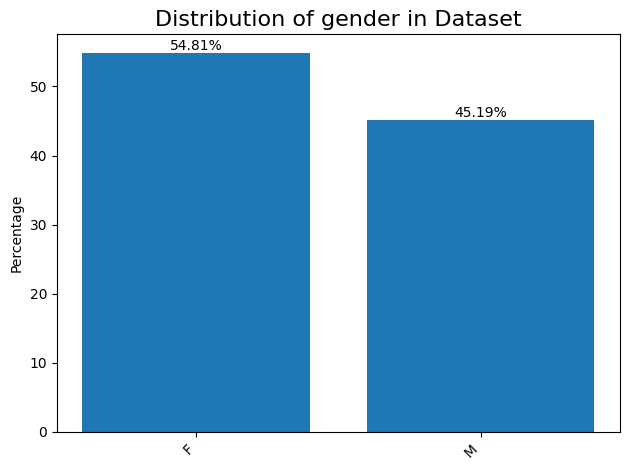

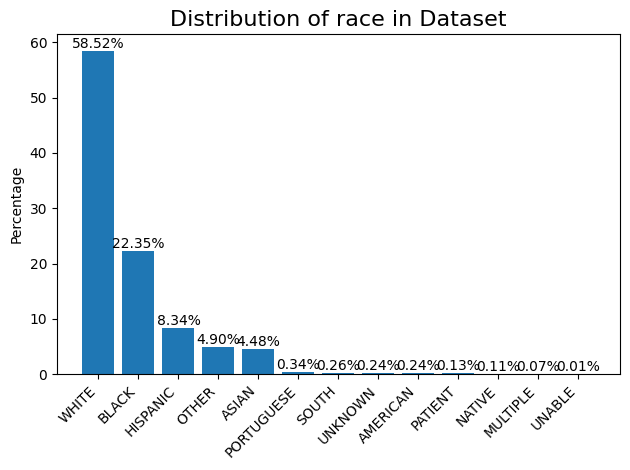

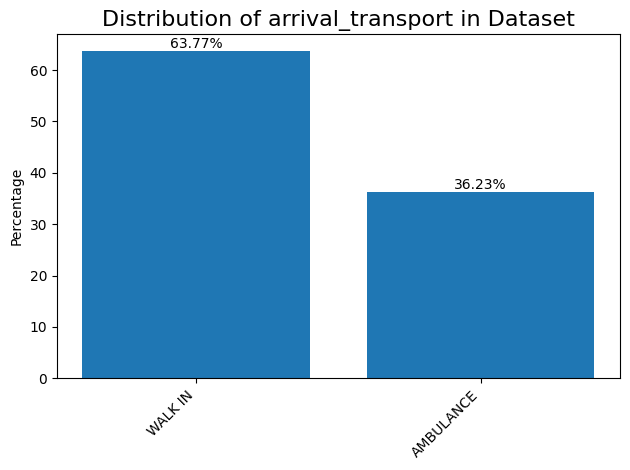

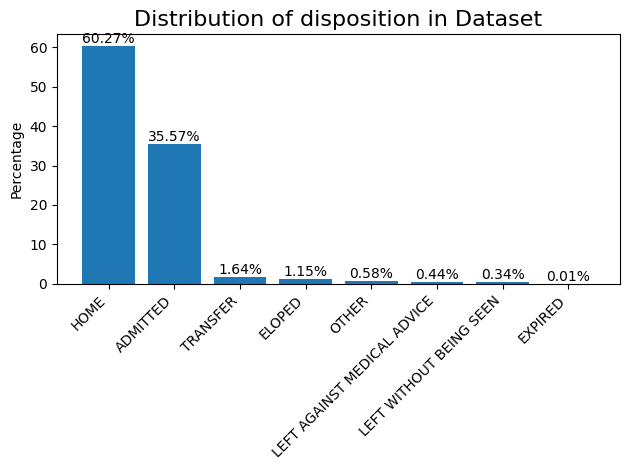

In [213]:
columns_of_interest = ['gender', 'race', 'arrival_transport', 'disposition']
for column in columns_of_interest:
    plot_column_categories(merged_df, column)

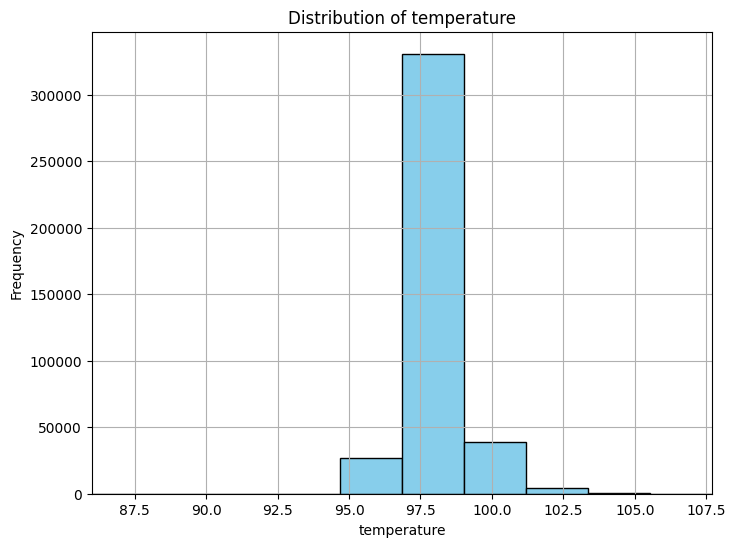

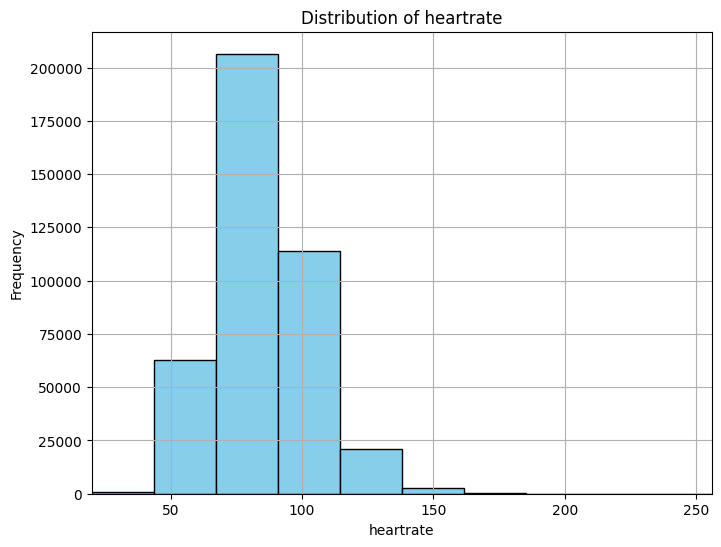

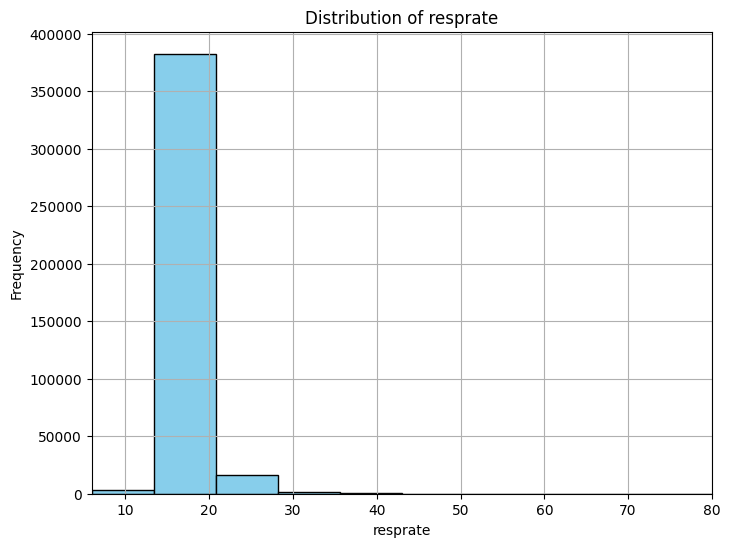

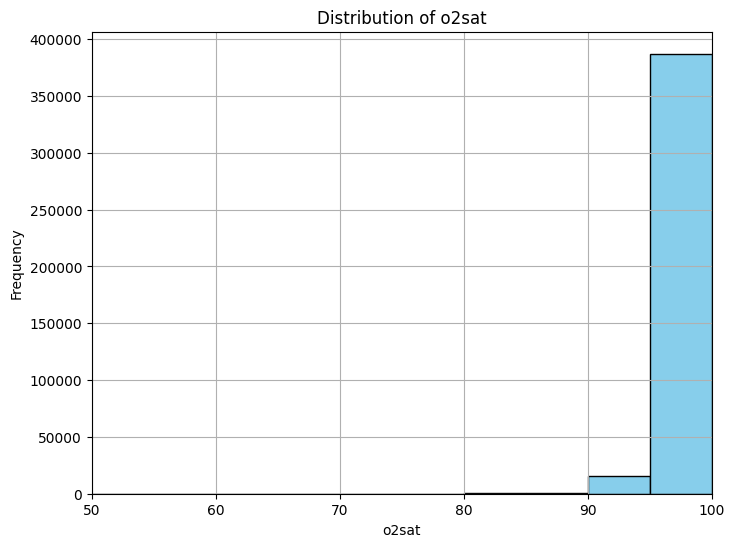

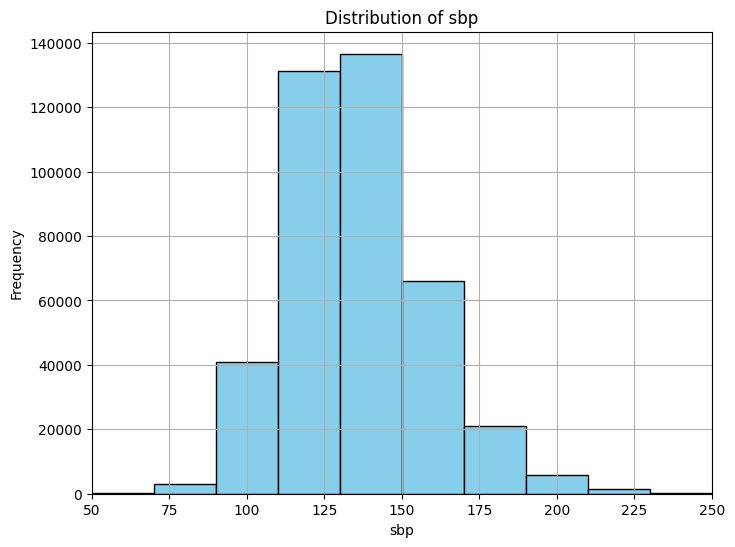

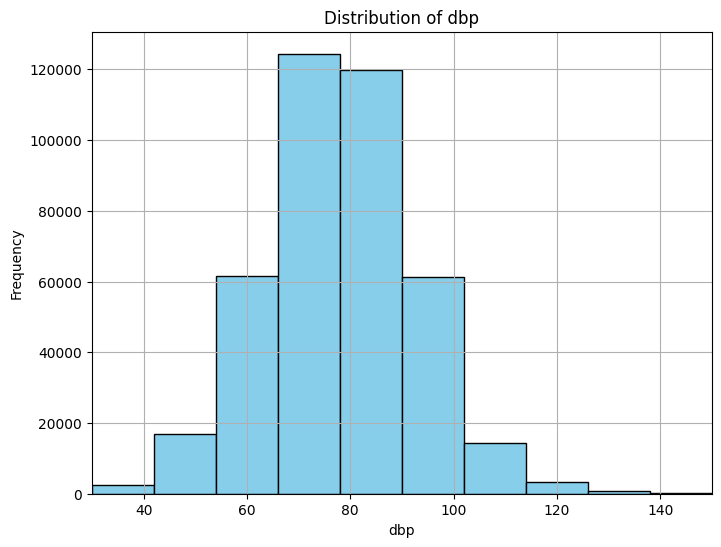

Column 'pain' is not numeric and cannot be plotted.


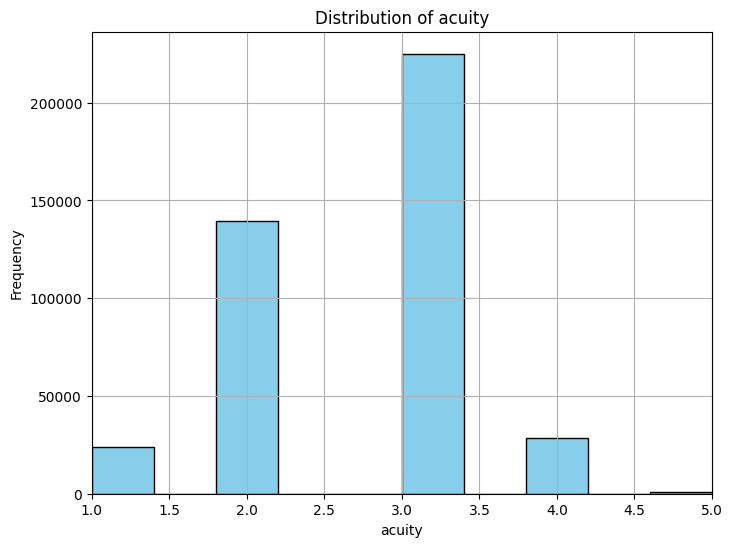

In [217]:
columns_of_interest = df_triage.columns[2:10]
for column in columns_of_interest:
    pct = plot_distribution(df_triage, column)